In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
from plotly.subplots import make_subplots
import plotly.graph_objects as go

pd.set_option('display.max_rows', 160)
pd.set_option('display.max_columns', 160)
pd.set_option('display.max_colwidth', 30)

import warnings
warnings.filterwarnings("ignore")

In [2]:
#load the saved training dataframe
path = 'data/'
df = pd.read_pickle(path+'df_complete.pkl')

X_train = df[~df.date_block_num.isin([0,1,33,34])]
y_train = X_train['item_cnt']
del X_train['item_cnt']

X_val = df[df['date_block_num']==33]
y_val = X_val['item_cnt']
del X_val['item_cnt']

X_test = df[df['date_block_num']==34].drop(columns='item_cnt')
X_test = X_test.reset_index()
del X_test['index']

#free memory
del df

In [3]:
X_train.shape

(7785068, 152)

## FineTuning Model

In [132]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

scoring = {'mse':make_scorer(mean_squared_error)}

## LightGBM

In [6]:
lgbm_params = {
    'num_leaves': [20, 127],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [5, 20],
    'lambda_l1': [0, 1.5],
    'lambda_l2': [0, 1]
    }

In [9]:
lgbm_rs = RandomizedSearchCV(
    estimator=lgb.LGBMRegressor(boosting_type='goss'),
    param_distributions=lgbm_params,
    n_jobs=2,
    scoring=scoring,
    verbose=2,
    refit=False,
    pre_dispatch=4
)

In [10]:
%time
lgbm_rs.fit(X=X_train, y=y_train)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.01 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 44.6min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed: 59.3min finished


RandomizedSearchCV(estimator=LGBMRegressor(boosting_type='goss'), n_jobs=2,
                   param_distributions={'lambda_l1': [0, 1.5],
                                        'lambda_l2': [0, 1],
                                        'min_data_in_leaf': [5, 20],
                                        'num_leaves': [20, 127],
                                        'reg_alpha': [0.1, 0.5]},
                   pre_dispatch=4, refit=False,
                   scoring={'mse': make_scorer(mean_squared_error)}, verbose=2)

In [11]:
pd.DataFrame(data=lgbm_rs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_alpha,param_num_leaves,param_min_data_in_leaf,param_lambda_l2,param_lambda_l1,params,split0_test_mse,split1_test_mse,split2_test_mse,split3_test_mse,split4_test_mse,mean_test_mse,std_test_mse,rank_test_mse
0,149.876846,6.374628,7.863432,0.229873,0.5,127,20,1,0,"{'reg_alpha': 0.5, 'num_le...",1.393640,0.903326,0.609143,0.788991,0.606389,0.860298,0.289461,9
1,124.298158,5.204175,6.808967,1.128104,0.5,20,20,0,0,"{'reg_alpha': 0.5, 'num_le...",1.294807,0.983293,0.648784,0.838493,0.618862,0.876848,0.247411,7
2,137.077368,3.564600,9.312408,0.985486,0.1,127,20,0,1.5,"{'reg_alpha': 0.1, 'num_le...",1.546848,1.021682,0.614442,0.790414,0.601908,0.915059,0.350570,3
3,123.735794,3.740446,7.590037,0.952652,0.5,20,5,0,1.5,"{'reg_alpha': 0.5, 'num_le...",1.332063,0.964051,0.648136,0.838277,0.619448,0.880395,0.258772,5
4,125.974750,1.290194,7.257392,1.157050,0.5,20,20,1,0,"{'reg_alpha': 0.5, 'num_le...",1.386240,0.980192,0.649665,0.837815,0.619954,0.894773,0.278454,4
5,126.240828,1.046848,7.405657,0.884615,0.1,20,20,0,0,"{'reg_alpha': 0.1, 'num_le...",1.294807,0.983293,0.648784,0.838493,0.618862,0.876848,0.247411,7
6,141.149235,1.348483,9.933970,1.008969,0.1,127,20,1,1.5,"{'reg_alpha': 0.1, 'num_le...",1.128144,1.067442,0.608537,0.790374,0.602734,0.839446,0.222301,10
7,143.530906,2.440023,10.649333,1.026457,0.1,127,5,1,0,"{'reg_alpha': 0.1, 'num_le...",1.620410,0.997936,0.611372,0.789164,0.598995,0.923575,0.377359,2
8,129.584145,1.308084,6.815952,1.123825,0.1,20,5,0,1.5,"{'reg_alpha': 0.1, 'num_le...",1.332063,0.964051,0.648136,0.838277,0.619448,0.880395,0.258772,5
9,125.951975,7.431518,6.467701,1.160244,0.5,20,5,1,1.5,"{'reg_alpha': 0.5, 'num_le...",1.879541,0.939474,0.647165,0.828484,0.618238,0.982580,0.463765,1


In [22]:
lgbm_rs.get_params()

{'reg_alpha': 0.5,
 'num_leaves': 20,
 'min_data_in_leaf': 5,
 'lambda_l2': 1,
 'lambda_l1': 1.5}

In [6]:
%%time
def build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val)
    model = lgb.train(params=params, train_set=lgb_train, valid_sets=(lgb_train, lgb_val), verbose_eval=50,
                     categorical_feature=cat_features)
    return model

lgbm_best_params = {
    'objective': 'mse',
    'metric': 'mse',
    'num_leaves': 1023,
    'min_data_in_leaf':10,
    'feature_fraction':0.7,
    'learning_rate': 0.01,
    'num_rounds': 1000,
    'early_stopping_rounds': 30,
    'seed': 1
}

cat_features = ['item_category_id','month','shop_id','shop_city']

lgb_model = build_lgb_model(lgbm_best_params, X_train, X_val, y_train, y_val, cat_features)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.203295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14916
[LightGBM] [Info] Number of data points in the train set: 7785068, number of used features: 152
[LightGBM] [Info] Start training from score 0.313209
Training until validation scores don't improve for 30 rounds
[50]	training's l2: 0.958234	valid_1's l2: 0.798391
[100]	training's l2: 0.70545	valid_1's l2: 0.653346
[150]	training's l2: 0.584769	valid_1's l2: 0.594476
[200]	training's l2: 0.521772	valid_1's l2: 0.568252
[250]	training's l2: 0.482793	valid_1's l2: 0.555263
[300]	training's l2: 0.455763	valid_1's l2: 0.549049
[350]	training's l2: 0.435217	valid_1's l2: 0.546825
[400]	training's l2: 0.418406	valid_1's l2: 0.545464
[450]	training's l2: 0.40463	valid_1's l2: 0.545138
Early stopping, best iteration is:
[440]	training's 

In [7]:
lgbm_pr_val = lgb_model.predict(X_val)
mean_squared_error(lgbm_pr_val, y_val)

0.5450523570402085

In [264]:
submission = pd.read_csv(path+'sample_submission.csv')
submission['item_cnt_month'] = lgb_model.predict(X_test)
submission[['ID', 'item_cnt_month']].to_csv(path+'lgbm_model.csv', index=False)

## SVM

In [2]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [9]:
svr_params={
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [1e0, 1e1, 1e2, 1e3],
    'gamma': np.arange(0.1, 0.4, 0.05)
}

In [ ]:
# preprocess data
svr_y_train = svr_x_train['item_cnt']
del svr_x_train['item_cnt']
svr_x_train = np.nan_to_num(svr_x_train.values)
scaler = StandardScaler().fit(svr_x_train)
svr_x_train = scaler.transform(svr_x_train)

In [18]:
svr_rs = RandomizedSearchCV(estimator=SVR(), 
                            param_distributions=svr_params,
                            n_jobs=2,
                            scoring=scoring,
                            verbose=4,
                            refit=False,
                            pre_dispatch=4)

svr_x_train = df[~df.date_block_num.isin([0,1,33,34])].dropna()

In [ ]:
%%time
svr_model = SVR(gamma=0.1, C=10)
svr_model.fit(svr_x_train, svr_y_train)

In [ ]:
svr_x_val = df[df['date_block_num']==33]
svr_x_val = np.nan_to_num(svr_x_val.values)
svr_x_val = scaler.transform(svr_x_val)

y_val = svr_x_val['item_cnt']
del svr_x_val['item_cnt']

In [ ]:
svr_pr = svr_model.predict(x_val)
mean_squared_error(svr_pr, y_val)

In [177]:
%%time
svr_rs.fit(svr_x_train, svr_y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 

In [174]:
pd.DataFrame(data=svr_rs.cv_results_)

AttributeError: 'RandomizedSearchCV' object has no attribute 'cv_results_'

In [ ]:
pd.DataFrame(data=svr_rs.cv_results_).to_csv('fine_tune_model/svr_model.csv')

## Random Forest

In [45]:
from sklearn.ensemble import RandomForestRegressor

In [46]:
rfr_x_train = X_train
rfr_y_train = y_train
rfr_x_train = np.nan_to_num(rfr_x_train.values)

In [48]:
rf_params = {
    'n_estimators': np.arange(10, 1000, 10),
    'max_depth': np.arange(5,15,2),
    'min_samples_split': np.arange(2,8,2),
    'min_samples_leaf': np.arange(1,15,3),
    'max_features': ['auto', 'sqrt', 'log2', 5, 10, 15, 20]
}

In [140]:
rfr_rs = RandomizedSearchCV(estimator=RandomForestRegressor(), 
                            param_distributions=rf_params,
                            n_jobs=2,
                            scoring=scoring,
                            verbose=4,
                            refit=False,
                            pre_dispatch=4)

In [141]:
rfr_rs.fit(rfr_x_train, rfr_y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 80.0min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed: 99.7min finished


RandomizedSearchCV(estimator=RandomForestRegressor(), n_jobs=2,
                   param_distributions={'max_depth': array([ 5,  7,  9, 11, 13]),
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         5, 10, 15, 20],
                                        'min_samples_leaf': array([ 1,  4,  7, 10, 13]),
                                        'min_samples_split': array([2, 4, 6]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 2...
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520,
       530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650,
       660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780,
       790, 800, 810, 820, 830, 840, 850, 860, 87

In [142]:
pd.DataFrame(data=rfr_rs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,split0_test_mse,split1_test_mse,split2_test_mse,split3_test_mse,split4_test_mse,mean_test_mse,std_test_mse,rank_test_mse
0,562.601714,8.852667,0.441756,0.011195,360,4,7,auto,9,"{'n_estimators': 360, 'min...",3.591692,1.673445,2.474587,1.157841,1.204020,2.020317,0.917181,10
1,31.805039,0.449355,0.273016,0.008742,290,4,1,sqrt,7,"{'n_estimators': 290, 'min...",4.241214,1.868706,2.732765,1.074970,1.272941,2.238119,1.155683,6
2,1418.650882,24.613575,1.101558,0.048215,900,2,13,auto,9,"{'n_estimators': 900, 'min...",3.613467,1.700484,2.478053,1.158376,1.200909,2.030258,0.923452,9
3,35.941575,0.490698,0.371498,0.008673,270,2,13,10,11,"{'n_estimators': 270, 'min...",4.162710,1.745904,2.600720,1.056522,1.240126,2.161196,1.134934,7
4,42.710188,0.488882,0.427367,0.021927,460,6,4,10,7,"{'n_estimators': 460, 'min...",4.398326,1.896071,2.774426,1.071755,1.291943,2.286504,1.209551,3
5,78.037539,1.072079,0.702871,0.037005,710,4,4,sqrt,7,"{'n_estimators': 710, 'min...",4.281505,1.863435,2.731494,1.087592,1.272835,2.247372,1.167415,5
6,23.892191,0.232165,0.150324,0.015426,180,4,4,20,5,"{'n_estimators': 180, 'min...",4.444997,1.955970,2.821131,1.144256,1.307259,2.334722,1.208817,2
7,9.502475,0.150211,0.098543,0.007957,100,4,10,10,7,"{'n_estimators': 100, 'min...",4.362700,1.860464,2.772128,1.096686,1.296075,2.277610,1.193663,4
8,27.520819,0.816352,0.424153,0.028430,520,2,7,log2,5,"{'n_estimators': 520, 'min...",5.074718,2.148033,3.095888,1.174496,1.394752,2.577578,1.418209,1
9,133.641327,7.388821,0.104959,0.009142,80,2,4,auto,9,"{'n_estimators': 80, 'min_...",3.615491,1.714356,2.506096,1.182274,1.219057,2.047455,0.918131,8


In [143]:
pd.DataFrame(data=rfr_rs.cv_results_).to_csv('fine_tune_model/rand_fores.csv')

In [47]:
%%time
rfr_model = RandomForestRegressor(n_estimators=360,
                                 min_samples_split=4,
                                 min_samples_leaf=7,
                                 max_features=15,
                                 max_depth=6)
rfr_model.fit(rfr_x_train, rfr_y_train)

CPU times: user 1h 43min 54s, sys: 18min 7s, total: 2h 2min 2s
Wall time: 2h 14min 6s


RandomForestRegressor(max_depth=6, max_features=15, min_samples_leaf=7,
                      min_samples_split=4, n_estimators=360)

In [48]:
rfr_x_val = np.nan_to_num(X_val.values)
rfr_pr_val = rfr_model.predict(rfr_x_val)
mean_squared_error(rfr_pr_val, y_val)

0.6839275100698441

In [49]:
rfr_x_test = X_test
rfr_x_test = np.nan_to_num(rfr_x_test.values)
rfr_y_test = rfr_model.predict(rfr_x_test)

In [36]:
submission = pd.read_csv(path+'sample_submission.csv')
submission['item_cnt_month'] = rfr_y_test.clip(0,20)
submission[['ID', 'item_cnt_month']].to_csv(path+'rfr_model.csv', index=False)

## CatBoost

In [8]:
import catboost as cb

In [9]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_val, y_val)

In [41]:
catboost_model = cb.CatBoostRegressor(loss_function='RMSE',
                                        learning_rate=0.01,
                                        depth=7,
                                        iterations=1000,
                                        min_data_in_leaf=10,
                                        early_stopping_rounds=30)

In [42]:
catboost_model.fit(train_dataset, eval_set=test_dataset)

0:	learn: 1.2423251	test: 1.0790083	best: 1.0790083 (0)	total: 1.17s	remaining: 6m 49s
1:	learn: 1.2376278	test: 1.0745782	best: 1.0745782 (1)	total: 2.03s	remaining: 5m 53s
2:	learn: 1.2329946	test: 1.0702930	best: 1.0702930 (2)	total: 2.82s	remaining: 5m 25s
3:	learn: 1.2284514	test: 1.0661377	best: 1.0661377 (3)	total: 3.6s	remaining: 5m 11s
4:	learn: 1.2240084	test: 1.0619535	best: 1.0619535 (4)	total: 4.38s	remaining: 5m 2s
5:	learn: 1.2195805	test: 1.0580013	best: 1.0580013 (5)	total: 5.19s	remaining: 4m 57s
6:	learn: 1.2152349	test: 1.0541230	best: 1.0541230 (6)	total: 6s	remaining: 4m 53s
7:	learn: 1.2109214	test: 1.0502440	best: 1.0502440 (7)	total: 6.76s	remaining: 4m 48s
8:	learn: 1.2066692	test: 1.0464060	best: 1.0464060 (8)	total: 7.52s	remaining: 4m 44s
9:	learn: 1.2025703	test: 1.0425628	best: 1.0425628 (9)	total: 8.22s	remaining: 4m 39s
10:	learn: 1.1984900	test: 1.0388552	best: 1.0388552 (10)	total: 8.96s	remaining: 4m 36s
11:	learn: 1.1945118	test: 1.0353125	best: 1.0

93:	learn: 1.0005031	test: 0.8634923	best: 0.8634923 (93)	total: 1m 10s	remaining: 3m 11s
94:	learn: 0.9992386	test: 0.8623919	best: 0.8623919 (94)	total: 1m 11s	remaining: 3m 10s
95:	learn: 0.9980001	test: 0.8613014	best: 0.8613014 (95)	total: 1m 11s	remaining: 3m 10s
96:	learn: 0.9968106	test: 0.8604841	best: 0.8604841 (96)	total: 1m 12s	remaining: 3m 10s
97:	learn: 0.9955984	test: 0.8595189	best: 0.8595189 (97)	total: 1m 13s	remaining: 3m 9s
98:	learn: 0.9944014	test: 0.8585173	best: 0.8585173 (98)	total: 1m 14s	remaining: 3m 8s
99:	learn: 0.9932449	test: 0.8576169	best: 0.8576169 (99)	total: 1m 15s	remaining: 3m 7s
100:	learn: 0.9921220	test: 0.8568041	best: 0.8568041 (100)	total: 1m 15s	remaining: 3m 6s
101:	learn: 0.9909662	test: 0.8559461	best: 0.8559461 (101)	total: 1m 16s	remaining: 3m 6s
102:	learn: 0.9898601	test: 0.8553735	best: 0.8553735 (102)	total: 1m 17s	remaining: 3m 5s
103:	learn: 0.9887502	test: 0.8545419	best: 0.8545419 (103)	total: 1m 18s	remaining: 3m 4s
104:	lear

183:	learn: 0.9325299	test: 0.8158882	best: 0.8158882 (183)	total: 2m 23s	remaining: 2m 9s
184:	learn: 0.9321057	test: 0.8156865	best: 0.8156865 (184)	total: 2m 24s	remaining: 2m 8s
185:	learn: 0.9316363	test: 0.8153132	best: 0.8153132 (185)	total: 2m 24s	remaining: 2m 7s
186:	learn: 0.9311985	test: 0.8149764	best: 0.8149764 (186)	total: 2m 25s	remaining: 2m 6s
187:	learn: 0.9307270	test: 0.8146840	best: 0.8146840 (187)	total: 2m 26s	remaining: 2m 6s
188:	learn: 0.9303547	test: 0.8143490	best: 0.8143490 (188)	total: 2m 27s	remaining: 2m 5s
189:	learn: 0.9298921	test: 0.8139882	best: 0.8139882 (189)	total: 2m 28s	remaining: 2m 4s
190:	learn: 0.9294652	test: 0.8136123	best: 0.8136123 (190)	total: 2m 29s	remaining: 2m 4s
191:	learn: 0.9290212	test: 0.8133996	best: 0.8133996 (191)	total: 2m 30s	remaining: 2m 3s
192:	learn: 0.9285711	test: 0.8130565	best: 0.8130565 (192)	total: 2m 31s	remaining: 2m 2s
193:	learn: 0.9281935	test: 0.8128952	best: 0.8128952 (193)	total: 2m 31s	remaining: 2m 2s

273:	learn: 0.9047878	test: 0.7987388	best: 0.7987388 (273)	total: 3m 36s	remaining: 1m
274:	learn: 0.9045804	test: 0.7986334	best: 0.7986334 (274)	total: 3m 37s	remaining: 59.2s
275:	learn: 0.9043811	test: 0.7985085	best: 0.7985085 (275)	total: 3m 37s	remaining: 58.4s
276:	learn: 0.9041613	test: 0.7983480	best: 0.7983480 (276)	total: 3m 38s	remaining: 57.6s
277:	learn: 0.9039407	test: 0.7981964	best: 0.7981964 (277)	total: 3m 39s	remaining: 56.8s
278:	learn: 0.9037484	test: 0.7980814	best: 0.7980814 (278)	total: 3m 40s	remaining: 56.1s
279:	learn: 0.9035526	test: 0.7980007	best: 0.7980007 (279)	total: 3m 41s	remaining: 55.3s
280:	learn: 0.9033591	test: 0.7979062	best: 0.7979062 (280)	total: 3m 41s	remaining: 54.5s
281:	learn: 0.9031340	test: 0.7978043	best: 0.7978043 (281)	total: 3m 42s	remaining: 53.7s
282:	learn: 0.9029517	test: 0.7977407	best: 0.7977407 (282)	total: 3m 43s	remaining: 52.9s
283:	learn: 0.9027747	test: 0.7976428	best: 0.7976428 (283)	total: 3m 44s	remaining: 52.1s
28

In [274]:
%%time
grid = {
        'learning_rate': [0.1],
        'depth': [10],
        'l2_leaf_reg': [1],
        'iterations': [1000]
       }

catboost_model.grid_search(grid,train_dataset)

0:	learn: 1.2310026	test: 1.2240899	best: 1.2240899 (0)	total: 3.18s	remaining: 52m 56s
1:	learn: 1.1826796	test: 1.1761028	best: 1.1761028 (1)	total: 6.13s	remaining: 50m 57s
2:	learn: 1.1405140	test: 1.1345478	best: 1.1345478 (2)	total: 8.57s	remaining: 47m 28s
3:	learn: 1.1048053	test: 1.0991756	best: 1.0991756 (3)	total: 11.3s	remaining: 46m 56s
4:	learn: 1.0745542	test: 1.0694564	best: 1.0694564 (4)	total: 14.1s	remaining: 46m 54s
5:	learn: 1.0482928	test: 1.0435475	best: 1.0435475 (5)	total: 16.5s	remaining: 45m 36s
6:	learn: 1.0253814	test: 1.0209066	best: 1.0209066 (6)	total: 18.9s	remaining: 44m 44s
7:	learn: 1.0058115	test: 1.0016063	best: 1.0016063 (7)	total: 21.4s	remaining: 44m 7s
8:	learn: 0.9889917	test: 0.9850251	best: 0.9850251 (8)	total: 23.8s	remaining: 43m 35s
9:	learn: 0.9746668	test: 0.9708648	best: 0.9708648 (9)	total: 26.2s	remaining: 43m 9s
10:	learn: 0.9621341	test: 0.9582790	best: 0.9582790 (10)	total: 28.6s	remaining: 42m 50s
11:	learn: 0.9512436	test: 0.947

91:	learn: 0.8031140	test: 0.8061992	best: 0.8061992 (91)	total: 3m 51s	remaining: 38m 7s
92:	learn: 0.8026198	test: 0.8058640	best: 0.8058640 (92)	total: 3m 54s	remaining: 38m 4s
93:	learn: 0.8016795	test: 0.8049877	best: 0.8049877 (93)	total: 3m 56s	remaining: 38m
94:	learn: 0.8010231	test: 0.8044225	best: 0.8044225 (94)	total: 3m 59s	remaining: 37m 59s
95:	learn: 0.8000803	test: 0.8036031	best: 0.8036031 (95)	total: 4m 1s	remaining: 37m 55s
96:	learn: 0.7995680	test: 0.8031040	best: 0.8031040 (96)	total: 4m 4s	remaining: 37m 52s
97:	learn: 0.7983208	test: 0.8020089	best: 0.8020089 (97)	total: 4m 6s	remaining: 37m 50s
98:	learn: 0.7975522	test: 0.8013570	best: 0.8013570 (98)	total: 4m 9s	remaining: 37m 48s
99:	learn: 0.7966161	test: 0.8004438	best: 0.8004438 (99)	total: 4m 12s	remaining: 37m 50s
100:	learn: 0.7958126	test: 0.7997214	best: 0.7997214 (100)	total: 4m 15s	remaining: 37m 54s
101:	learn: 0.7951770	test: 0.7990044	best: 0.7990044 (101)	total: 4m 17s	remaining: 37m 50s
102:	

180:	learn: 0.7565013	test: 0.7661677	best: 0.7661677 (180)	total: 7m 40s	remaining: 34m 41s
181:	learn: 0.7560822	test: 0.7658232	best: 0.7658232 (181)	total: 7m 42s	remaining: 34m 38s
182:	learn: 0.7556535	test: 0.7654486	best: 0.7654486 (182)	total: 7m 45s	remaining: 34m 37s
183:	learn: 0.7551800	test: 0.7650081	best: 0.7650081 (183)	total: 7m 48s	remaining: 34m 36s
184:	learn: 0.7549029	test: 0.7647952	best: 0.7647952 (184)	total: 7m 50s	remaining: 34m 34s
185:	learn: 0.7546296	test: 0.7645595	best: 0.7645595 (185)	total: 7m 53s	remaining: 34m 32s
186:	learn: 0.7543513	test: 0.7643149	best: 0.7643149 (186)	total: 7m 55s	remaining: 34m 29s
187:	learn: 0.7536450	test: 0.7636576	best: 0.7636576 (187)	total: 7m 58s	remaining: 34m 25s
188:	learn: 0.7533995	test: 0.7634970	best: 0.7634970 (188)	total: 8m	remaining: 34m 23s
189:	learn: 0.7531503	test: 0.7633534	best: 0.7633534 (189)	total: 8m 3s	remaining: 34m 20s
190:	learn: 0.7527703	test: 0.7629334	best: 0.7629334 (190)	total: 8m 5s	re

269:	learn: 0.7319330	test: 0.7477148	best: 0.7477148 (269)	total: 11m 22s	remaining: 30m 44s
270:	learn: 0.7316466	test: 0.7475069	best: 0.7475069 (270)	total: 11m 24s	remaining: 30m 42s
271:	learn: 0.7312504	test: 0.7471599	best: 0.7471599 (271)	total: 11m 27s	remaining: 30m 39s
272:	learn: 0.7310958	test: 0.7470336	best: 0.7470336 (272)	total: 11m 29s	remaining: 30m 37s
273:	learn: 0.7308933	test: 0.7469095	best: 0.7469095 (273)	total: 11m 32s	remaining: 30m 34s
274:	learn: 0.7306796	test: 0.7467167	best: 0.7467167 (274)	total: 11m 34s	remaining: 30m 31s
275:	learn: 0.7304823	test: 0.7465397	best: 0.7465397 (275)	total: 11m 37s	remaining: 30m 28s
276:	learn: 0.7299795	test: 0.7461315	best: 0.7461315 (276)	total: 11m 39s	remaining: 30m 26s
277:	learn: 0.7298185	test: 0.7460004	best: 0.7460004 (277)	total: 11m 42s	remaining: 30m 23s
278:	learn: 0.7296470	test: 0.7459249	best: 0.7459249 (278)	total: 11m 44s	remaining: 30m 20s
279:	learn: 0.7293605	test: 0.7456952	best: 0.7456952 (279)	

357:	learn: 0.7148829	test: 0.7360627	best: 0.7360627 (357)	total: 14m 59s	remaining: 26m 52s
358:	learn: 0.7147378	test: 0.7359958	best: 0.7359958 (358)	total: 15m 1s	remaining: 26m 49s
359:	learn: 0.7146202	test: 0.7359714	best: 0.7359714 (359)	total: 15m 3s	remaining: 26m 46s
360:	learn: 0.7144277	test: 0.7358593	best: 0.7358593 (360)	total: 15m 6s	remaining: 26m 44s
361:	learn: 0.7140241	test: 0.7355161	best: 0.7355161 (361)	total: 15m 9s	remaining: 26m 42s
362:	learn: 0.7138037	test: 0.7353299	best: 0.7353299 (362)	total: 15m 11s	remaining: 26m 39s
363:	learn: 0.7136241	test: 0.7351642	best: 0.7351642 (363)	total: 15m 13s	remaining: 26m 36s
364:	learn: 0.7132453	test: 0.7348480	best: 0.7348480 (364)	total: 15m 16s	remaining: 26m 34s
365:	learn: 0.7130715	test: 0.7348074	best: 0.7348074 (365)	total: 15m 18s	remaining: 26m 31s
366:	learn: 0.7129405	test: 0.7347216	best: 0.7347216 (366)	total: 15m 21s	remaining: 26m 28s
367:	learn: 0.7128443	test: 0.7347047	best: 0.7347047 (367)	tota

445:	learn: 0.7009015	test: 0.7269880	best: 0.7269880 (445)	total: 18m 36s	remaining: 23m 6s
446:	learn: 0.7007315	test: 0.7268562	best: 0.7268562 (446)	total: 18m 38s	remaining: 23m 3s
447:	learn: 0.7005921	test: 0.7268251	best: 0.7268251 (447)	total: 18m 40s	remaining: 23m 1s
448:	learn: 0.7004012	test: 0.7267338	best: 0.7267338 (448)	total: 18m 44s	remaining: 22m 59s
449:	learn: 0.7002845	test: 0.7266560	best: 0.7266560 (449)	total: 18m 46s	remaining: 22m 57s
450:	learn: 0.7001570	test: 0.7265665	best: 0.7265665 (450)	total: 18m 49s	remaining: 22m 54s
451:	learn: 0.7000505	test: 0.7265310	best: 0.7265310 (451)	total: 18m 52s	remaining: 22m 52s
452:	learn: 0.6998295	test: 0.7263800	best: 0.7263800 (452)	total: 18m 54s	remaining: 22m 49s
453:	learn: 0.6997233	test: 0.7263147	best: 0.7263147 (453)	total: 18m 56s	remaining: 22m 47s
454:	learn: 0.6995956	test: 0.7262797	best: 0.7262797 (454)	total: 18m 59s	remaining: 22m 44s
455:	learn: 0.6994963	test: 0.7262679	best: 0.7262679 (455)	tot

533:	learn: 0.6889750	test: 0.7200722	best: 0.7200722 (533)	total: 22m 17s	remaining: 19m 27s
534:	learn: 0.6887873	test: 0.7199693	best: 0.7199693 (534)	total: 22m 20s	remaining: 19m 24s
535:	learn: 0.6884674	test: 0.7197371	best: 0.7197371 (535)	total: 22m 22s	remaining: 19m 22s
536:	learn: 0.6883353	test: 0.7196503	best: 0.7196503 (536)	total: 22m 25s	remaining: 19m 19s
537:	learn: 0.6882196	test: 0.7195911	best: 0.7195911 (537)	total: 22m 27s	remaining: 19m 17s
538:	learn: 0.6881664	test: 0.7195738	best: 0.7195738 (538)	total: 22m 30s	remaining: 19m 14s
539:	learn: 0.6880918	test: 0.7195442	best: 0.7195442 (539)	total: 22m 32s	remaining: 19m 12s
540:	learn: 0.6878788	test: 0.7193995	best: 0.7193995 (540)	total: 22m 35s	remaining: 19m 9s
541:	learn: 0.6875820	test: 0.7191879	best: 0.7191879 (541)	total: 22m 37s	remaining: 19m 7s
542:	learn: 0.6874994	test: 0.7191773	best: 0.7191773 (542)	total: 22m 40s	remaining: 19m 4s
543:	learn: 0.6874365	test: 0.7191679	best: 0.7191679 (543)	tot

621:	learn: 0.6788466	test: 0.7147018	best: 0.7147018 (621)	total: 25m 55s	remaining: 15m 45s
622:	learn: 0.6787529	test: 0.7146246	best: 0.7146246 (622)	total: 25m 57s	remaining: 15m 42s
623:	learn: 0.6785857	test: 0.7145089	best: 0.7145089 (623)	total: 26m	remaining: 15m 40s
624:	learn: 0.6783957	test: 0.7144061	best: 0.7144061 (624)	total: 26m 2s	remaining: 15m 37s
625:	learn: 0.6783486	test: 0.7143934	best: 0.7143934 (625)	total: 26m 5s	remaining: 15m 35s
626:	learn: 0.6782374	test: 0.7143743	best: 0.7143743 (626)	total: 26m 7s	remaining: 15m 32s
627:	learn: 0.6780424	test: 0.7142221	best: 0.7142221 (627)	total: 26m 10s	remaining: 15m 30s
628:	learn: 0.6779657	test: 0.7142173	best: 0.7142173 (628)	total: 26m 12s	remaining: 15m 27s
629:	learn: 0.6778792	test: 0.7141873	best: 0.7141873 (629)	total: 26m 15s	remaining: 15m 25s
630:	learn: 0.6777378	test: 0.7141005	best: 0.7141005 (630)	total: 26m 17s	remaining: 15m 22s
631:	learn: 0.6776745	test: 0.7140884	best: 0.7140884 (631)	total: 

709:	learn: 0.6691207	test: 0.7097369	best: 0.7097369 (709)	total: 29m 34s	remaining: 12m 4s
710:	learn: 0.6689164	test: 0.7095089	best: 0.7095089 (710)	total: 29m 37s	remaining: 12m 2s
711:	learn: 0.6688031	test: 0.7094398	best: 0.7094398 (711)	total: 29m 39s	remaining: 11m 59s
712:	learn: 0.6687161	test: 0.7094103	best: 0.7094103 (712)	total: 29m 41s	remaining: 11m 57s
713:	learn: 0.6686552	test: 0.7094081	best: 0.7094081 (713)	total: 29m 44s	remaining: 11m 54s
714:	learn: 0.6682894	test: 0.7090519	best: 0.7090519 (714)	total: 29m 47s	remaining: 11m 52s
715:	learn: 0.6682009	test: 0.7090065	best: 0.7090065 (715)	total: 29m 49s	remaining: 11m 49s
716:	learn: 0.6681137	test: 0.7089441	best: 0.7089441 (716)	total: 29m 52s	remaining: 11m 47s
717:	learn: 0.6680275	test: 0.7089096	best: 0.7089096 (717)	total: 29m 54s	remaining: 11m 44s
718:	learn: 0.6679364	test: 0.7088642	best: 0.7088642 (718)	total: 29m 57s	remaining: 11m 42s
719:	learn: 0.6678669	test: 0.7088360	best: 0.7088360 (719)	to

797:	learn: 0.6603523	test: 0.7051588	best: 0.7051588 (797)	total: 33m 17s	remaining: 8m 25s
798:	learn: 0.6602779	test: 0.7051120	best: 0.7051120 (798)	total: 33m 20s	remaining: 8m 23s
799:	learn: 0.6601910	test: 0.7050518	best: 0.7050518 (799)	total: 33m 22s	remaining: 8m 20s
800:	learn: 0.6600876	test: 0.7050419	best: 0.7050419 (800)	total: 33m 25s	remaining: 8m 18s
801:	learn: 0.6600048	test: 0.7050097	best: 0.7050097 (801)	total: 33m 27s	remaining: 8m 15s
802:	learn: 0.6599582	test: 0.7049956	best: 0.7049956 (802)	total: 33m 30s	remaining: 8m 13s
803:	learn: 0.6597428	test: 0.7048126	best: 0.7048126 (803)	total: 33m 32s	remaining: 8m 10s
804:	learn: 0.6596617	test: 0.7047528	best: 0.7047528 (804)	total: 33m 35s	remaining: 8m 8s
805:	learn: 0.6595835	test: 0.7047119	best: 0.7047119 (805)	total: 33m 37s	remaining: 8m 5s
806:	learn: 0.6595075	test: 0.7046512	best: 0.7046512 (806)	total: 33m 41s	remaining: 8m 3s
807:	learn: 0.6594506	test: 0.7046199	best: 0.7046199 (807)	total: 33m 43

886:	learn: 0.6528282	test: 0.7015674	best: 0.7015674 (886)	total: 37m 5s	remaining: 4m 43s
887:	learn: 0.6527813	test: 0.7015692	best: 0.7015674 (886)	total: 37m 8s	remaining: 4m 41s
888:	learn: 0.6527045	test: 0.7015552	best: 0.7015552 (888)	total: 37m 11s	remaining: 4m 38s
889:	learn: 0.6526567	test: 0.7015369	best: 0.7015369 (889)	total: 37m 14s	remaining: 4m 36s
890:	learn: 0.6526089	test: 0.7015298	best: 0.7015298 (890)	total: 37m 16s	remaining: 4m 33s
891:	learn: 0.6525396	test: 0.7015205	best: 0.7015205 (891)	total: 37m 19s	remaining: 4m 31s
892:	learn: 0.6524131	test: 0.7014775	best: 0.7014775 (892)	total: 37m 21s	remaining: 4m 28s
893:	learn: 0.6523565	test: 0.7014711	best: 0.7014711 (893)	total: 37m 24s	remaining: 4m 26s
894:	learn: 0.6522851	test: 0.7014589	best: 0.7014589 (894)	total: 37m 26s	remaining: 4m 23s
895:	learn: 0.6522248	test: 0.7014260	best: 0.7014260 (895)	total: 37m 28s	remaining: 4m 21s
896:	learn: 0.6521510	test: 0.7013900	best: 0.7013900 (896)	total: 37m 3

975:	learn: 0.6460709	test: 0.6988010	best: 0.6988010 (975)	total: 40m 48s	remaining: 1m
976:	learn: 0.6460165	test: 0.6987838	best: 0.6987838 (976)	total: 40m 50s	remaining: 57.7s
977:	learn: 0.6459318	test: 0.6987883	best: 0.6987838 (976)	total: 40m 53s	remaining: 55.2s
978:	learn: 0.6458615	test: 0.6987854	best: 0.6987838 (976)	total: 40m 55s	remaining: 52.7s
979:	learn: 0.6457400	test: 0.6986988	best: 0.6986988 (979)	total: 40m 58s	remaining: 50.2s
980:	learn: 0.6456727	test: 0.6986856	best: 0.6986856 (980)	total: 41m	remaining: 47.7s
981:	learn: 0.6456016	test: 0.6986910	best: 0.6986856 (980)	total: 41m 3s	remaining: 45.2s
982:	learn: 0.6455520	test: 0.6986791	best: 0.6986791 (982)	total: 41m 5s	remaining: 42.6s
983:	learn: 0.6454056	test: 0.6985633	best: 0.6985633 (983)	total: 41m 8s	remaining: 40.1s
984:	learn: 0.6452581	test: 0.6984877	best: 0.6984877 (984)	total: 41m 10s	remaining: 37.6s
985:	learn: 0.6451816	test: 0.6984489	best: 0.6984489 (985)	total: 41m 13s	remaining: 35.1

62:	learn: 0.8246225	test: 0.8312634	best: 0.8312634 (62)	total: 6m 48s	remaining: 1h 41m 21s
63:	learn: 0.8238550	test: 0.8305627	best: 0.8305627 (63)	total: 6m 55s	remaining: 1h 41m 13s
64:	learn: 0.8229516	test: 0.8297788	best: 0.8297788 (64)	total: 7m 1s	remaining: 1h 41m 8s
65:	learn: 0.8217913	test: 0.8287774	best: 0.8287774 (65)	total: 7m 8s	remaining: 1h 41m 2s
66:	learn: 0.8210285	test: 0.8281315	best: 0.8281315 (66)	total: 7m 15s	remaining: 1h 40m 57s
67:	learn: 0.8199522	test: 0.8271318	best: 0.8271318 (67)	total: 7m 21s	remaining: 1h 40m 49s
68:	learn: 0.8187969	test: 0.8260306	best: 0.8260306 (68)	total: 7m 27s	remaining: 1h 40m 38s
69:	learn: 0.8181200	test: 0.8254791	best: 0.8254791 (69)	total: 7m 33s	remaining: 1h 40m 29s
70:	learn: 0.8171271	test: 0.8245765	best: 0.8245765 (70)	total: 7m 40s	remaining: 1h 40m 25s
71:	learn: 0.8161883	test: 0.8236724	best: 0.8236724 (71)	total: 7m 46s	remaining: 1h 40m 15s
72:	learn: 0.8154375	test: 0.8230316	best: 0.8230316 (72)	total:

149:	learn: 0.7664036	test: 0.7796715	best: 0.7796715 (149)	total: 16m 7s	remaining: 1h 31m 22s
150:	learn: 0.7658549	test: 0.7792049	best: 0.7792049 (150)	total: 16m 14s	remaining: 1h 31m 16s
151:	learn: 0.7654821	test: 0.7788755	best: 0.7788755 (151)	total: 16m 20s	remaining: 1h 31m 9s
152:	learn: 0.7651297	test: 0.7786058	best: 0.7786058 (152)	total: 16m 26s	remaining: 1h 31m 3s
153:	learn: 0.7646607	test: 0.7782479	best: 0.7782479 (153)	total: 16m 33s	remaining: 1h 30m 55s
154:	learn: 0.7642377	test: 0.7778927	best: 0.7778927 (154)	total: 16m 39s	remaining: 1h 30m 48s
155:	learn: 0.7636844	test: 0.7774554	best: 0.7774554 (155)	total: 16m 45s	remaining: 1h 30m 42s
156:	learn: 0.7632218	test: 0.7770723	best: 0.7770723 (156)	total: 16m 52s	remaining: 1h 30m 34s
157:	learn: 0.7627360	test: 0.7766400	best: 0.7766400 (157)	total: 16m 58s	remaining: 1h 30m 28s
158:	learn: 0.7623214	test: 0.7763192	best: 0.7763192 (158)	total: 17m 4s	remaining: 1h 30m 20s
159:	learn: 0.7620006	test: 0.7760

234:	learn: 0.7372464	test: 0.7573080	best: 0.7573080 (234)	total: 25m 32s	remaining: 1h 23m 7s
235:	learn: 0.7370532	test: 0.7571990	best: 0.7571990 (235)	total: 25m 38s	remaining: 1h 22m 59s
236:	learn: 0.7368142	test: 0.7570183	best: 0.7570183 (236)	total: 25m 44s	remaining: 1h 22m 52s
237:	learn: 0.7364413	test: 0.7567480	best: 0.7567480 (237)	total: 25m 51s	remaining: 1h 22m 45s
238:	learn: 0.7362050	test: 0.7565711	best: 0.7565711 (238)	total: 25m 57s	remaining: 1h 22m 38s
239:	learn: 0.7359547	test: 0.7564110	best: 0.7564110 (239)	total: 26m 3s	remaining: 1h 22m 31s
240:	learn: 0.7357235	test: 0.7562641	best: 0.7562641 (240)	total: 26m 9s	remaining: 1h 22m 23s
241:	learn: 0.7354956	test: 0.7561181	best: 0.7561181 (241)	total: 26m 16s	remaining: 1h 22m 16s
242:	learn: 0.7352076	test: 0.7559052	best: 0.7559052 (242)	total: 26m 22s	remaining: 1h 22m 9s
243:	learn: 0.7348621	test: 0.7556283	best: 0.7556283 (243)	total: 26m 28s	remaining: 1h 22m 3s
244:	learn: 0.7345388	test: 0.75540

319:	learn: 0.7175022	test: 0.7438817	best: 0.7438817 (319)	total: 34m 34s	remaining: 1h 13m 28s
320:	learn: 0.7173651	test: 0.7438256	best: 0.7438256 (320)	total: 34m 40s	remaining: 1h 13m 21s
321:	learn: 0.7171888	test: 0.7437013	best: 0.7437013 (321)	total: 34m 47s	remaining: 1h 13m 14s
322:	learn: 0.7170277	test: 0.7436027	best: 0.7436027 (322)	total: 34m 53s	remaining: 1h 13m 7s
323:	learn: 0.7168184	test: 0.7434737	best: 0.7434737 (323)	total: 34m 59s	remaining: 1h 13m 1s
324:	learn: 0.7166335	test: 0.7433876	best: 0.7433876 (324)	total: 35m 6s	remaining: 1h 12m 54s
325:	learn: 0.7164400	test: 0.7432826	best: 0.7432826 (325)	total: 35m 12s	remaining: 1h 12m 48s
326:	learn: 0.7162768	test: 0.7432039	best: 0.7432039 (326)	total: 35m 19s	remaining: 1h 12m 41s
327:	learn: 0.7161187	test: 0.7431368	best: 0.7431368 (327)	total: 35m 25s	remaining: 1h 12m 34s
328:	learn: 0.7158834	test: 0.7429790	best: 0.7429790 (328)	total: 35m 31s	remaining: 1h 12m 27s
329:	learn: 0.7156625	test: 0.742

405:	learn: 0.7022085	test: 0.7345467	best: 0.7345467 (405)	total: 43m 41s	remaining: 1h 3m 54s
406:	learn: 0.7020355	test: 0.7344440	best: 0.7344440 (406)	total: 43m 47s	remaining: 1h 3m 48s
407:	learn: 0.7019183	test: 0.7343757	best: 0.7343757 (407)	total: 43m 53s	remaining: 1h 3m 41s
408:	learn: 0.7017724	test: 0.7342849	best: 0.7342849 (408)	total: 44m	remaining: 1h 3m 34s
409:	learn: 0.7016185	test: 0.7341812	best: 0.7341812 (409)	total: 44m 6s	remaining: 1h 3m 28s
410:	learn: 0.7014171	test: 0.7340759	best: 0.7340759 (410)	total: 44m 13s	remaining: 1h 3m 22s
411:	learn: 0.7012136	test: 0.7339372	best: 0.7339372 (411)	total: 44m 19s	remaining: 1h 3m 15s
412:	learn: 0.7011234	test: 0.7338964	best: 0.7338964 (412)	total: 44m 25s	remaining: 1h 3m 8s
413:	learn: 0.7009961	test: 0.7338367	best: 0.7338367 (413)	total: 44m 32s	remaining: 1h 3m 2s
414:	learn: 0.7008781	test: 0.7337974	best: 0.7337974 (414)	total: 44m 38s	remaining: 1h 2m 55s
415:	learn: 0.7006699	test: 0.7337078	best: 0.7

493:	learn: 0.6891437	test: 0.7271376	best: 0.7271376 (493)	total: 53m 3s	remaining: 54m 21s
494:	learn: 0.6889992	test: 0.7270630	best: 0.7270630 (494)	total: 53m 10s	remaining: 54m 14s
495:	learn: 0.6888922	test: 0.7270341	best: 0.7270341 (495)	total: 53m 16s	remaining: 54m 8s
496:	learn: 0.6887431	test: 0.7269446	best: 0.7269446 (496)	total: 53m 22s	remaining: 54m 1s
497:	learn: 0.6886304	test: 0.7268844	best: 0.7268844 (497)	total: 53m 29s	remaining: 53m 55s
498:	learn: 0.6885067	test: 0.7268315	best: 0.7268315 (498)	total: 53m 35s	remaining: 53m 48s
499:	learn: 0.6883154	test: 0.7267010	best: 0.7267010 (499)	total: 53m 41s	remaining: 53m 41s
500:	learn: 0.6882211	test: 0.7266614	best: 0.7266614 (500)	total: 53m 48s	remaining: 53m 35s
501:	learn: 0.6880773	test: 0.7265770	best: 0.7265770 (501)	total: 53m 54s	remaining: 53m 29s
502:	learn: 0.6879988	test: 0.7265527	best: 0.7265527 (502)	total: 54m 1s	remaining: 53m 22s
503:	learn: 0.6878251	test: 0.7264422	best: 0.7264422 (503)	tota

581:	learn: 0.6777998	test: 0.7211266	best: 0.7211266 (581)	total: 1h 2m 32s	remaining: 44m 55s
582:	learn: 0.6776969	test: 0.7211014	best: 0.7211014 (582)	total: 1h 2m 40s	remaining: 44m 49s
583:	learn: 0.6775801	test: 0.7210222	best: 0.7210222 (583)	total: 1h 2m 47s	remaining: 44m 43s
584:	learn: 0.6774504	test: 0.7209550	best: 0.7209550 (584)	total: 1h 2m 54s	remaining: 44m 37s
585:	learn: 0.6773283	test: 0.7208799	best: 0.7208799 (585)	total: 1h 3m	remaining: 44m 31s
586:	learn: 0.6772409	test: 0.7208578	best: 0.7208578 (586)	total: 1h 3m 7s	remaining: 44m 24s
587:	learn: 0.6770550	test: 0.7207333	best: 0.7207333 (587)	total: 1h 3m 13s	remaining: 44m 18s
588:	learn: 0.6769268	test: 0.7206880	best: 0.7206880 (588)	total: 1h 3m 19s	remaining: 44m 11s
589:	learn: 0.6767941	test: 0.7206019	best: 0.7206019 (589)	total: 1h 3m 26s	remaining: 44m 4s
590:	learn: 0.6766677	test: 0.7205359	best: 0.7205359 (590)	total: 1h 3m 32s	remaining: 43m 58s
591:	learn: 0.6765705	test: 0.7204858	best: 0.

667:	learn: 0.6685452	test: 0.7170804	best: 0.7170804 (667)	total: 1h 11m 43s	remaining: 35m 39s
668:	learn: 0.6684407	test: 0.7170645	best: 0.7170645 (668)	total: 1h 11m 50s	remaining: 35m 32s
669:	learn: 0.6683469	test: 0.7170005	best: 0.7170005 (669)	total: 1h 11m 56s	remaining: 35m 26s
670:	learn: 0.6681884	test: 0.7169074	best: 0.7169074 (670)	total: 1h 12m 3s	remaining: 35m 19s
671:	learn: 0.6680887	test: 0.7168798	best: 0.7168798 (671)	total: 1h 12m 10s	remaining: 35m 13s
672:	learn: 0.6679636	test: 0.7168328	best: 0.7168328 (672)	total: 1h 12m 18s	remaining: 35m 7s
673:	learn: 0.6678787	test: 0.7167962	best: 0.7167962 (673)	total: 1h 12m 25s	remaining: 35m 1s
674:	learn: 0.6678039	test: 0.7167716	best: 0.7167716 (674)	total: 1h 12m 31s	remaining: 34m 55s
675:	learn: 0.6676990	test: 0.7167357	best: 0.7167357 (675)	total: 1h 12m 37s	remaining: 34m 48s
676:	learn: 0.6675871	test: 0.7166582	best: 0.7166582 (676)	total: 1h 12m 43s	remaining: 34m 42s
677:	learn: 0.6675001	test: 0.716

752:	learn: 0.6601669	test: 0.7133252	best: 0.7133252 (752)	total: 1h 20m 52s	remaining: 26m 31s
753:	learn: 0.6600817	test: 0.7132967	best: 0.7132967 (753)	total: 1h 20m 59s	remaining: 26m 25s
754:	learn: 0.6599720	test: 0.7132358	best: 0.7132358 (754)	total: 1h 21m 5s	remaining: 26m 18s
755:	learn: 0.6598690	test: 0.7131888	best: 0.7131888 (755)	total: 1h 21m 11s	remaining: 26m 12s
756:	learn: 0.6597894	test: 0.7131573	best: 0.7131573 (756)	total: 1h 21m 18s	remaining: 26m 5s
757:	learn: 0.6596982	test: 0.7131306	best: 0.7131306 (757)	total: 1h 21m 24s	remaining: 25m 59s
758:	learn: 0.6596106	test: 0.7130976	best: 0.7130976 (758)	total: 1h 21m 31s	remaining: 25m 53s
759:	learn: 0.6595174	test: 0.7130361	best: 0.7130361 (759)	total: 1h 21m 37s	remaining: 25m 46s
760:	learn: 0.6593859	test: 0.7129396	best: 0.7129396 (760)	total: 1h 21m 43s	remaining: 25m 40s
761:	learn: 0.6592999	test: 0.7129102	best: 0.7129102 (761)	total: 1h 21m 50s	remaining: 25m 33s
762:	learn: 0.6592042	test: 0.71

837:	learn: 0.6520705	test: 0.7095143	best: 0.7095143 (837)	total: 1h 30m	remaining: 17m 24s
838:	learn: 0.6519880	test: 0.7094929	best: 0.7094929 (838)	total: 1h 30m 6s	remaining: 17m 17s
839:	learn: 0.6519196	test: 0.7094839	best: 0.7094839 (839)	total: 1h 30m 13s	remaining: 17m 11s
840:	learn: 0.6518447	test: 0.7094431	best: 0.7094431 (840)	total: 1h 30m 19s	remaining: 17m 4s
841:	learn: 0.6517653	test: 0.7094254	best: 0.7094254 (841)	total: 1h 30m 25s	remaining: 16m 58s
842:	learn: 0.6516697	test: 0.7093931	best: 0.7093931 (842)	total: 1h 30m 32s	remaining: 16m 51s
843:	learn: 0.6515904	test: 0.7093569	best: 0.7093569 (843)	total: 1h 30m 38s	remaining: 16m 45s
844:	learn: 0.6514741	test: 0.7092791	best: 0.7092791 (844)	total: 1h 30m 44s	remaining: 16m 38s
845:	learn: 0.6513994	test: 0.7092575	best: 0.7092575 (845)	total: 1h 30m 51s	remaining: 16m 32s
846:	learn: 0.6513338	test: 0.7092150	best: 0.7092150 (846)	total: 1h 30m 57s	remaining: 16m 25s
847:	learn: 0.6512431	test: 0.709166

922:	learn: 0.6450984	test: 0.7066071	best: 0.7066071 (922)	total: 1h 39m 13s	remaining: 8m 16s
923:	learn: 0.6450056	test: 0.7065650	best: 0.7065650 (923)	total: 1h 39m 21s	remaining: 8m 10s
924:	learn: 0.6449451	test: 0.7065540	best: 0.7065540 (924)	total: 1h 39m 28s	remaining: 8m 3s
925:	learn: 0.6448522	test: 0.7065068	best: 0.7065068 (925)	total: 1h 39m 35s	remaining: 7m 57s
926:	learn: 0.6447847	test: 0.7064862	best: 0.7064862 (926)	total: 1h 39m 42s	remaining: 7m 51s
927:	learn: 0.6446952	test: 0.7064726	best: 0.7064726 (927)	total: 1h 39m 49s	remaining: 7m 44s
928:	learn: 0.6446385	test: 0.7064607	best: 0.7064607 (928)	total: 1h 39m 56s	remaining: 7m 38s
929:	learn: 0.6445446	test: 0.7064139	best: 0.7064139 (929)	total: 1h 40m 2s	remaining: 7m 31s
930:	learn: 0.6444728	test: 0.7063928	best: 0.7063928 (930)	total: 1h 40m 9s	remaining: 7m 25s
931:	learn: 0.6444270	test: 0.7063888	best: 0.7063888 (931)	total: 1h 40m 15s	remaining: 7m 18s
932:	learn: 0.6443504	test: 0.7063392	best:

{'params': {'depth': 10,
  'l2_leaf_reg': 1,
  'iterations': 1000,
  'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [43]:
catboost_pr_val = catboost_model.predict(X_val)
mean_squared_error(catboost_pr_val, y_val)

0.6256596510771776

In [44]:
submission = pd.read_csv(path+'sample_submission.csv')
submission['item_cnt_month'] = catboost_model.predict(X_test)
submission[['ID', 'item_cnt_month']].to_csv(path+'cat_boost_model.csv', index=False)

In [253]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [254]:
mean_absolute_percentage_error(y_val.values, catboost_pr_val)

inf

## XGBoost

In [37]:
import xgboost as xgb

In [40]:
xgb_model = xgb.XGBRegressor( colsample_bytree = 0.3, 
                            learning_rate = 0.2,
                            max_depth = 5, 
                            alpha = 10, 
                            n_estimators = 10)

In [39]:
xgb_x_train = X_train
xgb_y_train = y_train
xgb_x_train = np.nan_to_num(xgb_x_train.values)

In [ ]:
%%time
xgb_model.fit(xgb_x_train, xgb_y_train)

In [ ]:
xgb_pred_val = xgb_model.predict(X_test)

In [42]:
xgb_x_val = np.nan_to_num(X_val.values)
xgb_pr_val = xgb_model.predict(xgb_x_val)
mean_squared_error(xgb_pred_val, y_val)

In [ ]:
submission = pd.read_csv(path+'sample_submission.csv')
submission['item_cnt_month'] = xgb_pred.predict(X_test)
submission[['ID', 'item_cnt_month']].to_csv(path+'cat_boost_model.csv', index=False)

## Compare

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt

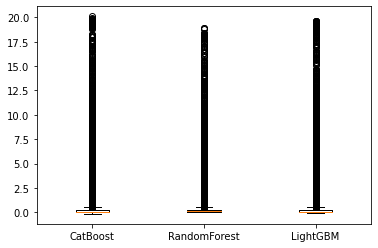

In [55]:
plt.boxplot([catboost_pr_val, rfr_pr_val, lgbm_pr_val],
            labels=['CatBoost', 'RandomForest', 'LightGBM'])
plt.show()

In [52]:
df_predictions = pd.DataFrame(data=[ [x,y,z,u] for x,y,z,u in zip(catboost_pr_val, rfr_pr_val, lgbm_pr_val, y_val) ], columns=['CatBoost', 'RandomForest', 'LightGBM', 'y_val'])

## Корреляция прогнозов

In [53]:
df_predictions.corr()

,CatBoost,RandomForest,LightGBM,y_val
CatBoost,1.000000,0.971394,0.956337,0.682661
RandomForest,0.971394,1.000000,0.923128,0.652725
LightGBM,0.956337,0.923128,1.000000,0.731263
y_val,0.682661,0.652725,0.731263,1.000000


## График зависимости ошибки модели от размера обучающей выборки

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

In [146]:
sizes = [0.3, 0.5, 0.7, 0.9]

In [256]:
def split_data(X, y, size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)
    X_train, y_train = pd.DataFrame(X_train), pd.DataFrame(y_train)
    X_test, y_test = pd.DataFrame(X_test), pd.DataFrame(y_test)
    return X_train, X_test, y_train, y_test

In [255]:
def get_errors(model, X, y, X_val, y_val):
    copy_model = model
    sizes = [0.3, 0.5, 0.7, 0.9]
    errors = []
    for size in sizes:
        print(f'data size: {size}')
        X_train, X_test, y_train, y_test = split_data(X, y, size)
        model.fit(X_train, y_train)
#         err = mse(model.predict(X_test), y_test)
        err = mse(model.predict(X_val), y_val)
        errors.append(err)
        model = copy_model 
    return errors

In [267]:
_rfr_model = RandomForestRegressor(n_estimators=100,
                                   min_samples_split=4,
                                   min_samples_leaf=7,
                                   max_features=15,
                                   max_depth=6)
rfr_errors = get_errors(_rfr_model, rfr_x_train, rfr_y_train, rfr_x_val, y_val)

data size: 0.3
data size: 0.5
data size: 0.7
data size: 0.9


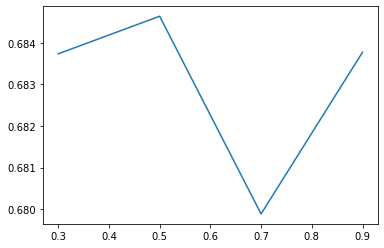

In [268]:
plt.plot(sizes, rfr_errors)

In [269]:
pd.DataFrame(rfr_errors).to_excel('data/rfr_errors.xlsx')

In [261]:
_catboost_model = cb.CatBoostRegressor(loss_function='RMSE',
                                        learning_rate=0.01,
                                        depth=7,
                                        iterations=500,
                                        min_data_in_leaf=10)
cb_errors = get_errors(_catboost_model, X_train, y_train, X_val, y_val)

data size: 0.3
0:	learn: 1.2407944	total: 756ms	remaining: 6m 16s
1:	learn: 1.2361255	total: 1.41s	remaining: 5m 52s
2:	learn: 1.2314717	total: 2.02s	remaining: 5m 33s
3:	learn: 1.2269210	total: 2.56s	remaining: 5m 17s
4:	learn: 1.2224572	total: 3.11s	remaining: 5m 7s
5:	learn: 1.2180434	total: 3.66s	remaining: 5m 1s
6:	learn: 1.2137104	total: 4.24s	remaining: 4m 58s
7:	learn: 1.2094071	total: 4.8s	remaining: 4m 55s
8:	learn: 1.2052550	total: 5.33s	remaining: 4m 50s
9:	learn: 1.2010925	total: 5.92s	remaining: 4m 50s
10:	learn: 1.1970551	total: 6.41s	remaining: 4m 44s
11:	learn: 1.1930200	total: 6.93s	remaining: 4m 41s
12:	learn: 1.1890365	total: 7.46s	remaining: 4m 39s
13:	learn: 1.1852004	total: 7.93s	remaining: 4m 35s
14:	learn: 1.1814066	total: 8.4s	remaining: 4m 31s
15:	learn: 1.1776166	total: 8.88s	remaining: 4m 28s
16:	learn: 1.1738762	total: 9.36s	remaining: 4m 25s
17:	learn: 1.1701612	total: 9.89s	remaining: 4m 24s
18:	learn: 1.1665504	total: 10.4s	remaining: 4m 22s
19:	learn: 

157:	learn: 0.9445308	total: 1m 29s	remaining: 3m 14s
158:	learn: 0.9439228	total: 1m 30s	remaining: 3m 14s
159:	learn: 0.9433268	total: 1m 31s	remaining: 3m 13s
160:	learn: 0.9427677	total: 1m 31s	remaining: 3m 12s
161:	learn: 0.9422077	total: 1m 32s	remaining: 3m 12s
162:	learn: 0.9415966	total: 1m 32s	remaining: 3m 11s
163:	learn: 0.9410409	total: 1m 33s	remaining: 3m 11s
164:	learn: 0.9405419	total: 1m 33s	remaining: 3m 10s
165:	learn: 0.9399827	total: 1m 34s	remaining: 3m 9s
166:	learn: 0.9394407	total: 1m 34s	remaining: 3m 9s
167:	learn: 0.9388593	total: 1m 35s	remaining: 3m 8s
168:	learn: 0.9383290	total: 1m 36s	remaining: 3m 8s
169:	learn: 0.9378193	total: 1m 36s	remaining: 3m 7s
170:	learn: 0.9372738	total: 1m 37s	remaining: 3m 7s
171:	learn: 0.9367365	total: 1m 37s	remaining: 3m 6s
172:	learn: 0.9362846	total: 1m 38s	remaining: 3m 6s
173:	learn: 0.9357967	total: 1m 39s	remaining: 3m 5s
174:	learn: 0.9353078	total: 1m 39s	remaining: 3m 5s
175:	learn: 0.9348064	total: 1m 40s	re

311:	learn: 0.8961881	total: 3m 1s	remaining: 1m 49s
312:	learn: 0.8959687	total: 3m 2s	remaining: 1m 48s
313:	learn: 0.8957749	total: 3m 2s	remaining: 1m 48s
314:	learn: 0.8956112	total: 3m 3s	remaining: 1m 47s
315:	learn: 0.8954021	total: 3m 4s	remaining: 1m 47s
316:	learn: 0.8952320	total: 3m 4s	remaining: 1m 46s
317:	learn: 0.8951084	total: 3m 5s	remaining: 1m 46s
318:	learn: 0.8949553	total: 3m 6s	remaining: 1m 45s
319:	learn: 0.8947944	total: 3m 6s	remaining: 1m 44s
320:	learn: 0.8946390	total: 3m 7s	remaining: 1m 44s
321:	learn: 0.8944921	total: 3m 7s	remaining: 1m 43s
322:	learn: 0.8943382	total: 3m 8s	remaining: 1m 43s
323:	learn: 0.8941409	total: 3m 9s	remaining: 1m 42s
324:	learn: 0.8940050	total: 3m 9s	remaining: 1m 42s
325:	learn: 0.8938486	total: 3m 10s	remaining: 1m 41s
326:	learn: 0.8937148	total: 3m 10s	remaining: 1m 40s
327:	learn: 0.8935241	total: 3m 11s	remaining: 1m 40s
328:	learn: 0.8933846	total: 3m 11s	remaining: 1m 39s
329:	learn: 0.8932364	total: 3m 12s	remain

466:	learn: 0.8769625	total: 4m 33s	remaining: 19.3s
467:	learn: 0.8768735	total: 4m 33s	remaining: 18.7s
468:	learn: 0.8767653	total: 4m 34s	remaining: 18.1s
469:	learn: 0.8766663	total: 4m 34s	remaining: 17.6s
470:	learn: 0.8765792	total: 4m 35s	remaining: 17s
471:	learn: 0.8764717	total: 4m 36s	remaining: 16.4s
472:	learn: 0.8763871	total: 4m 36s	remaining: 15.8s
473:	learn: 0.8762780	total: 4m 37s	remaining: 15.2s
474:	learn: 0.8761743	total: 4m 37s	remaining: 14.6s
475:	learn: 0.8761036	total: 4m 38s	remaining: 14s
476:	learn: 0.8760030	total: 4m 38s	remaining: 13.4s
477:	learn: 0.8759014	total: 4m 39s	remaining: 12.9s
478:	learn: 0.8757921	total: 4m 39s	remaining: 12.3s
479:	learn: 0.8756895	total: 4m 40s	remaining: 11.7s
480:	learn: 0.8755864	total: 4m 40s	remaining: 11.1s
481:	learn: 0.8754858	total: 4m 41s	remaining: 10.5s
482:	learn: 0.8754033	total: 4m 41s	remaining: 9.91s
483:	learn: 0.8753286	total: 4m 42s	remaining: 9.33s
484:	learn: 0.8752512	total: 4m 42s	remaining: 8.7

124:	learn: 0.9685243	total: 50.6s	remaining: 2m 31s
125:	learn: 0.9676850	total: 50.9s	remaining: 2m 31s
126:	learn: 0.9668560	total: 51.4s	remaining: 2m 30s
127:	learn: 0.9660931	total: 51.8s	remaining: 2m 30s
128:	learn: 0.9653104	total: 52.2s	remaining: 2m 30s
129:	learn: 0.9645488	total: 52.7s	remaining: 2m 29s
130:	learn: 0.9637330	total: 53.1s	remaining: 2m 29s
131:	learn: 0.9629384	total: 53.5s	remaining: 2m 29s
132:	learn: 0.9621276	total: 53.9s	remaining: 2m 28s
133:	learn: 0.9613383	total: 54.4s	remaining: 2m 28s
134:	learn: 0.9605695	total: 54.7s	remaining: 2m 27s
135:	learn: 0.9598663	total: 55.1s	remaining: 2m 27s
136:	learn: 0.9591491	total: 55.5s	remaining: 2m 27s
137:	learn: 0.9583899	total: 56s	remaining: 2m 26s
138:	learn: 0.9576768	total: 56.4s	remaining: 2m 26s
139:	learn: 0.9569710	total: 56.8s	remaining: 2m 26s
140:	learn: 0.9562380	total: 57.3s	remaining: 2m 26s
141:	learn: 0.9555278	total: 57.8s	remaining: 2m 25s
142:	learn: 0.9548588	total: 58.2s	remaining: 2m

278:	learn: 0.9029668	total: 1m 56s	remaining: 1m 31s
279:	learn: 0.9027471	total: 1m 56s	remaining: 1m 31s
280:	learn: 0.9025307	total: 1m 56s	remaining: 1m 31s
281:	learn: 0.9022958	total: 1m 57s	remaining: 1m 30s
282:	learn: 0.9020771	total: 1m 57s	remaining: 1m 30s
283:	learn: 0.9018463	total: 1m 58s	remaining: 1m 29s
284:	learn: 0.9016171	total: 1m 58s	remaining: 1m 29s
285:	learn: 0.9014375	total: 1m 58s	remaining: 1m 28s
286:	learn: 0.9012360	total: 1m 59s	remaining: 1m 28s
287:	learn: 0.9010098	total: 1m 59s	remaining: 1m 28s
288:	learn: 0.9007930	total: 2m	remaining: 1m 27s
289:	learn: 0.9006062	total: 2m	remaining: 1m 27s
290:	learn: 0.9003907	total: 2m	remaining: 1m 26s
291:	learn: 0.9001974	total: 2m 1s	remaining: 1m 26s
292:	learn: 0.9000203	total: 2m 1s	remaining: 1m 25s
293:	learn: 0.8998358	total: 2m 2s	remaining: 1m 25s
294:	learn: 0.8996185	total: 2m 2s	remaining: 1m 25s
295:	learn: 0.8994647	total: 2m 2s	remaining: 1m 24s
296:	learn: 0.8992676	total: 2m 3s	remaining:

433:	learn: 0.8811094	total: 3m 2s	remaining: 27.7s
434:	learn: 0.8809928	total: 3m 2s	remaining: 27.3s
435:	learn: 0.8808328	total: 3m 3s	remaining: 26.9s
436:	learn: 0.8807379	total: 3m 3s	remaining: 26.4s
437:	learn: 0.8806680	total: 3m 3s	remaining: 26s
438:	learn: 0.8805734	total: 3m 4s	remaining: 25.6s
439:	learn: 0.8804946	total: 3m 4s	remaining: 25.2s
440:	learn: 0.8803622	total: 3m 5s	remaining: 24.8s
441:	learn: 0.8802384	total: 3m 5s	remaining: 24.3s
442:	learn: 0.8801206	total: 3m 5s	remaining: 23.9s
443:	learn: 0.8800312	total: 3m 6s	remaining: 23.5s
444:	learn: 0.8799196	total: 3m 6s	remaining: 23.1s
445:	learn: 0.8798439	total: 3m 7s	remaining: 22.7s
446:	learn: 0.8797690	total: 3m 7s	remaining: 22.2s
447:	learn: 0.8796963	total: 3m 7s	remaining: 21.8s
448:	learn: 0.8795908	total: 3m 8s	remaining: 21.4s
449:	learn: 0.8794789	total: 3m 8s	remaining: 21s
450:	learn: 0.8793844	total: 3m 9s	remaining: 20.6s
451:	learn: 0.8792799	total: 3m 9s	remaining: 20.1s
452:	learn: 0.87

90:	learn: 1.0047915	total: 20s	remaining: 1m 29s
91:	learn: 1.0034606	total: 20.2s	remaining: 1m 29s
92:	learn: 1.0021446	total: 20.4s	remaining: 1m 29s
93:	learn: 1.0008298	total: 20.7s	remaining: 1m 29s
94:	learn: 0.9995539	total: 20.9s	remaining: 1m 28s
95:	learn: 0.9982767	total: 21.1s	remaining: 1m 28s
96:	learn: 0.9970022	total: 21.3s	remaining: 1m 28s
97:	learn: 0.9957776	total: 21.6s	remaining: 1m 28s
98:	learn: 0.9945971	total: 21.8s	remaining: 1m 28s
99:	learn: 0.9934016	total: 22s	remaining: 1m 28s
100:	learn: 0.9922528	total: 22.3s	remaining: 1m 27s
101:	learn: 0.9911374	total: 22.5s	remaining: 1m 27s
102:	learn: 0.9900506	total: 22.8s	remaining: 1m 27s
103:	learn: 0.9889097	total: 23.1s	remaining: 1m 27s
104:	learn: 0.9877831	total: 23.3s	remaining: 1m 27s
105:	learn: 0.9866627	total: 23.5s	remaining: 1m 27s
106:	learn: 0.9855734	total: 23.8s	remaining: 1m 27s
107:	learn: 0.9844896	total: 24s	remaining: 1m 27s
108:	learn: 0.9834040	total: 24.3s	remaining: 1m 27s
109:	lear

247:	learn: 0.9096446	total: 1m 2s	remaining: 1m 3s
248:	learn: 0.9093438	total: 1m 3s	remaining: 1m 3s
249:	learn: 0.9090838	total: 1m 3s	remaining: 1m 3s
250:	learn: 0.9088378	total: 1m 3s	remaining: 1m 3s
251:	learn: 0.9085674	total: 1m 4s	remaining: 1m 3s
252:	learn: 0.9083256	total: 1m 4s	remaining: 1m 2s
253:	learn: 0.9080962	total: 1m 4s	remaining: 1m 2s
254:	learn: 0.9078347	total: 1m 4s	remaining: 1m 2s
255:	learn: 0.9076014	total: 1m 5s	remaining: 1m 2s
256:	learn: 0.9073506	total: 1m 5s	remaining: 1m 1s
257:	learn: 0.9070981	total: 1m 5s	remaining: 1m 1s
258:	learn: 0.9068186	total: 1m 6s	remaining: 1m 1s
259:	learn: 0.9066213	total: 1m 6s	remaining: 1m 1s
260:	learn: 0.9064045	total: 1m 6s	remaining: 1m
261:	learn: 0.9061632	total: 1m 6s	remaining: 1m
262:	learn: 0.9059440	total: 1m 7s	remaining: 1m
263:	learn: 0.9057302	total: 1m 7s	remaining: 1m
264:	learn: 0.9054694	total: 1m 7s	remaining: 1m
265:	learn: 0.9052124	total: 1m 8s	remaining: 59.9s
266:	learn: 0.9050082	total

403:	learn: 0.8830288	total: 1m 46s	remaining: 25.2s
404:	learn: 0.8829337	total: 1m 46s	remaining: 24.9s
405:	learn: 0.8828324	total: 1m 46s	remaining: 24.7s
406:	learn: 0.8827123	total: 1m 46s	remaining: 24.4s
407:	learn: 0.8825920	total: 1m 47s	remaining: 24.1s
408:	learn: 0.8824872	total: 1m 47s	remaining: 23.9s
409:	learn: 0.8823877	total: 1m 47s	remaining: 23.6s
410:	learn: 0.8822532	total: 1m 47s	remaining: 23.3s
411:	learn: 0.8821579	total: 1m 47s	remaining: 23.1s
412:	learn: 0.8819925	total: 1m 48s	remaining: 22.8s
413:	learn: 0.8818878	total: 1m 48s	remaining: 22.5s
414:	learn: 0.8817865	total: 1m 48s	remaining: 22.3s
415:	learn: 0.8816884	total: 1m 48s	remaining: 22s
416:	learn: 0.8816035	total: 1m 49s	remaining: 21.7s
417:	learn: 0.8815024	total: 1m 49s	remaining: 21.5s
418:	learn: 0.8813501	total: 1m 49s	remaining: 21.2s
419:	learn: 0.8812367	total: 1m 49s	remaining: 20.9s
420:	learn: 0.8811601	total: 1m 50s	remaining: 20.7s
421:	learn: 0.8810464	total: 1m 50s	remaining: 2

62:	learn: 1.0492751	total: 4.46s	remaining: 30.9s
63:	learn: 1.0472987	total: 4.53s	remaining: 30.9s
64:	learn: 1.0453791	total: 4.61s	remaining: 30.8s
65:	learn: 1.0434143	total: 4.68s	remaining: 30.8s
66:	learn: 1.0415278	total: 4.75s	remaining: 30.7s
67:	learn: 1.0396707	total: 4.82s	remaining: 30.6s
68:	learn: 1.0378729	total: 4.91s	remaining: 30.6s
69:	learn: 1.0361124	total: 5s	remaining: 30.7s
70:	learn: 1.0343348	total: 5.08s	remaining: 30.7s
71:	learn: 1.0325203	total: 5.16s	remaining: 30.7s
72:	learn: 1.0307829	total: 5.22s	remaining: 30.6s
73:	learn: 1.0290884	total: 5.29s	remaining: 30.5s
74:	learn: 1.0274934	total: 5.36s	remaining: 30.4s
75:	learn: 1.0258715	total: 5.44s	remaining: 30.4s
76:	learn: 1.0242024	total: 5.51s	remaining: 30.3s
77:	learn: 1.0226156	total: 5.59s	remaining: 30.2s
78:	learn: 1.0210570	total: 5.67s	remaining: 30.2s
79:	learn: 1.0194945	total: 5.74s	remaining: 30.1s
80:	learn: 1.0179577	total: 5.83s	remaining: 30.1s
81:	learn: 1.0164595	total: 5.89s	

222:	learn: 0.9136419	total: 17.8s	remaining: 22.1s
223:	learn: 0.9132711	total: 17.9s	remaining: 22.1s
224:	learn: 0.9129194	total: 18.1s	remaining: 22.1s
225:	learn: 0.9126217	total: 18.2s	remaining: 22s
226:	learn: 0.9122752	total: 18.3s	remaining: 22s
227:	learn: 0.9119766	total: 18.4s	remaining: 21.9s
228:	learn: 0.9116367	total: 18.5s	remaining: 21.9s
229:	learn: 0.9113686	total: 18.6s	remaining: 21.9s
230:	learn: 0.9110233	total: 18.7s	remaining: 21.8s
231:	learn: 0.9106933	total: 18.8s	remaining: 21.8s
232:	learn: 0.9103394	total: 19s	remaining: 21.7s
233:	learn: 0.9100576	total: 19.1s	remaining: 21.7s
234:	learn: 0.9097751	total: 19.2s	remaining: 21.6s
235:	learn: 0.9094311	total: 19.3s	remaining: 21.6s
236:	learn: 0.9091771	total: 19.4s	remaining: 21.5s
237:	learn: 0.9088649	total: 19.5s	remaining: 21.4s
238:	learn: 0.9085812	total: 19.6s	remaining: 21.4s
239:	learn: 0.9083417	total: 19.7s	remaining: 21.3s
240:	learn: 0.9080677	total: 19.8s	remaining: 21.3s
241:	learn: 0.9077

382:	learn: 0.8808724	total: 34.6s	remaining: 10.6s
383:	learn: 0.8807344	total: 34.7s	remaining: 10.5s
384:	learn: 0.8805581	total: 34.8s	remaining: 10.4s
385:	learn: 0.8804347	total: 34.8s	remaining: 10.3s
386:	learn: 0.8803191	total: 34.9s	remaining: 10.2s
387:	learn: 0.8801946	total: 35s	remaining: 10.1s
388:	learn: 0.8800612	total: 35.2s	remaining: 10.1s
389:	learn: 0.8799394	total: 35.4s	remaining: 9.97s
390:	learn: 0.8798316	total: 35.5s	remaining: 9.89s
391:	learn: 0.8797407	total: 35.6s	remaining: 9.8s
392:	learn: 0.8795705	total: 35.7s	remaining: 9.71s
393:	learn: 0.8794543	total: 35.8s	remaining: 9.62s
394:	learn: 0.8793605	total: 35.8s	remaining: 9.53s
395:	learn: 0.8792403	total: 35.9s	remaining: 9.43s
396:	learn: 0.8791332	total: 36s	remaining: 9.34s
397:	learn: 0.8790347	total: 36.1s	remaining: 9.25s
398:	learn: 0.8788965	total: 36.2s	remaining: 9.17s
399:	learn: 0.8787855	total: 36.4s	remaining: 9.09s
400:	learn: 0.8786598	total: 36.5s	remaining: 9s
401:	learn: 0.878511

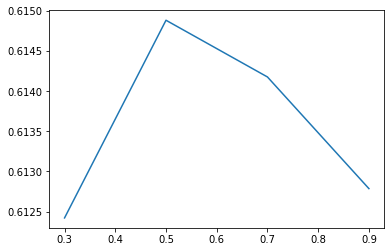

In [262]:
plt.plot(sizes, cb_errors)

In [265]:
pd.DataFrame(cb_errors).to_excel('data/cb_errors.xlsx')

In [258]:
_lgbm_model = lgb.LGBMRegressor(objective= 'mse',
                                    metric='mse',
                                    num_leaves= 1023,
                                    min_data_in_leaf=10,
                                    feature_fraction=0.7,
                                    learning_rate=0.01,
                                    num_rounds= 1000)
lgbm_errors = get_errors(_lgbm_model, X_train, y_train, X_val, y_val)

data size: 0.3
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] num_iterations is set=1000, num_rounds=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
data size: 0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] num_iterations is set=1000, num_rounds=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
data size: 0.7
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] num_iterations is set=1000, num_rounds=1000 will be ignored. Current value: num_iterat

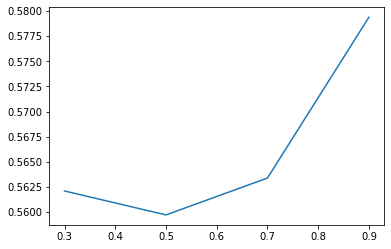

In [259]:
plt.plot(sizes, lgbm_errors)

In [264]:
pd.DataFrame(lgbm_errors).to_excel('data/lgbm_errors.xlsx')

## Важные признаки

LightGBM

Text(0.5, 1.0, 'LightGBM Feature Importance')

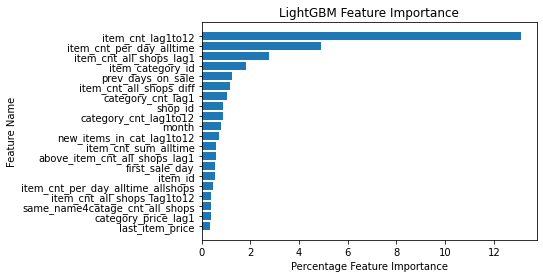

In [57]:
sorted_idx = lgb_model.feature_importance(importance_type='gain').argsort()[::-1][:20][::-1]
plt.barh(X_train.columns[sorted_idx], lgb_model.feature_importance(importance_type='gain')[sorted_idx]/1e7)
plt.xlabel("Percentage Feature Importance")
plt.ylabel("Feature Name")
plt.title("LightGBM Feature Importance")

In [95]:
sorted_idx = lgb_model.feature_importance(importance_type='gain').argsort()[::-1][:20][::-1]
values = lgb_model.feature_importance(importance_type='gain')[sorted_idx]/1e7
keys = X_train.columns[sorted_idx].values
lgbm_dict = {key: val for key, val in zip(keys, values)}
lgbm_pd = pd.DataFrame([ [k,v] for k, v in lgbm_dict.items() ])
lgbm_pd.to_excel('data/lgbm_dict.xlsx')

RandomForest

Text(0.5, 1.0, 'RandomForest Feature Importance')

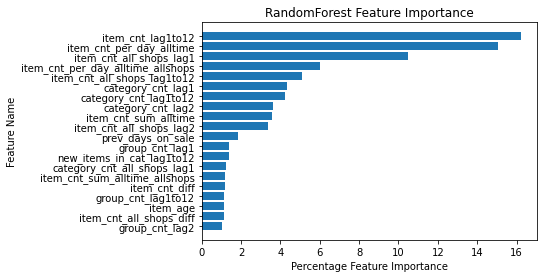

In [55]:
sorted_idx = rfr_model.feature_importances_.argsort()[::-1][:20][::-1]
plt.barh(X_train.columns[sorted_idx], rfr_model.feature_importances_[sorted_idx]*100)
plt.xlabel("Percentage Feature Importance")
plt.ylabel("Feature Name")
plt.title("RandomForest Feature Importance")

In [94]:
sorted_idx = rfr_model.feature_importances_.argsort()[::-1][:20][::-1]
values = rfr_model.feature_importances_[sorted_idx]*100
keys = X_train.columns[sorted_idx].values
rf_dict = {key: val for key, val in zip(keys, values)}
rf_pd = pd.DataFrame([ [k,v] for k, v in rf_dict.items() ])
rf_pd.to_excel('data/rfr_dict.xlsx')

CatBoost

Text(0.5, 1.0, 'CatBoost Feature Importance')

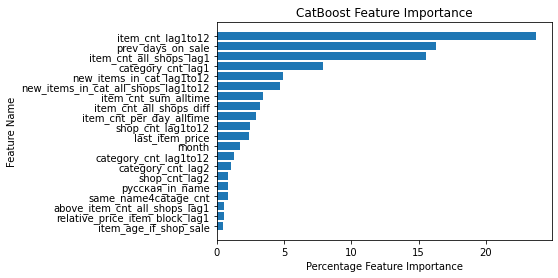

In [56]:
sorted_idx = catboost_model.get_feature_importance().argsort()[::-1][:20][::-1]
plt.barh(X_train.columns[sorted_idx], catboost_model.feature_importances_[sorted_idx])
plt.xlabel("Percentage Feature Importance")
plt.ylabel("Feature Name")
plt.title("CatBoost Feature Importance")

In [96]:
sorted_idx = catboost_model.get_feature_importance().argsort()[::-1][:20][::-1]
values = catboost_model.feature_importances_[sorted_idx]
keys = X_train.columns[sorted_idx].values
cat_boost_dict = {key: val for key, val in zip(keys, values)}
cb_pd = pd.DataFrame([ [k,v] for k, v in cat_boost_dict.items() ])
cb_pd.to_excel('data/cat_boost_dict.xlsx')

Features Inner Merge

In [113]:
# read dictionary
cb_pd = pd.read_excel('data/cat_boost_dict.xlsx', index_col=0).rename(columns={0: 'name', 1:'val'})
rfr_pd = pd.read_excel('data/rfr_dict.xlsx', index_col=0).rename(columns={0: 'name', 1:'val'})
lgbm_pd = pd.read_excel('data/lgbm_dict.xlsx', index_col=0).rename(columns={0: 'name', 1:'val'})

In [130]:
# merge dictionary
merge_pd = cb_pd.merge(rfr_pd, how='left', left_on='name', right_on='name').dropna()
merge_pd = lgbm_pd.merge(merge_pd, how='left', left_on='name', right_on='name').dropna()
merge_pd = merge_pd.rename(columns={'val_y': 'RandomForest', 'val_x': 'CatBoost', 'val': 'LightGBM', 'name': 'Feature Name'})
# sum in total for each features
merge_pd['s'] = merge_pd['LightGBM'] + merge_pd['CatBoost'] + merge_pd['RandomForest']
merge_pd = merge_pd.sort_values(by='s', ascending=False)
# save to excel
merge_pd.to_excel('data/merge_pd.xlsx')
merge_pd

,Feature Name,LightGBM,CatBoost,RandomForest,s
19,item_cnt_lag1to12,13.098515,23.697439,16.203700,52.999654
17,item_cnt_all_shops_lag1,2.762688,15.527680,10.474530,28.764898
18,item_cnt_per_day_alltime,4.892644,2.917817,15.071134,22.881595
15,prev_days_on_sale,1.235963,16.295472,1.843044,19.374478
13,category_cnt_lag1,1.046235,7.894245,4.328348,13.268828
8,item_cnt_sum_alltime,0.594173,3.453214,3.581333,7.628719
9,new_items_in_cat_lag1to12,0.711901,4.945268,1.364124,7.021293
11,category_cnt_lag1to12,0.856296,1.296254,4.256014,6.408564
14,item_cnt_all_shops_diff,1.165331,3.241153,1.116510,5.522994


## Статистическая значимость

In [228]:
prediction_list = [catboost_pr_val, lgbm_pr_val, rfr_pr_val, y_val]
labels = ['CatBoost', 'LightGBM', 'RandomForest', 'y_val']

### Student's t-test

In [177]:
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=6.006, p=0.000
Different distributions (reject H0)


In [232]:
from scipy.stats import ttest_ind

t_test_df = pd.DataFrame(columns=labels, index=labels)

for m1, n_m1 in zip(prediction_list, labels):
    for m2, n_m2 in zip(prediction_list, labels):
        stat, p = ttest_ind(m1, m2)
        t_test_df.loc[n_m2, n_m1] = round(p, 4)

In [233]:
t_test_df

,CatBoost,LightGBM,RandomForest,y_val
CatBoost,1,0,0.0012,0
LightGBM,0,1,0,0.0286
RandomForest,0.0012,0,1,0
y_val,0,0.0286,0,1


In [ ]:
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

### Paired Student's t-test

In [234]:
from scipy.stats import ttest_rel

ttest_rel_df = pd.DataFrame(columns=labels, index=labels)

for m1, n_m1 in zip(prediction_list, labels):
    for m2, n_m2 in zip(prediction_list, labels):
        stat, p = ttest_rel(m1, m2)
        ttest_rel_df.loc[n_m2, n_m1] = round(p, 4)

In [235]:
ttest_rel_df

,CatBoost,LightGBM,RandomForest,y_val
CatBoost,NaN,0,0,0
LightGBM,0,NaN,0,0.0001
RandomForest,0,0,NaN,0
y_val,0,0.0001,0,NaN


### Analysis of Variance test

In [ ]:
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

In [236]:
from scipy.stats import f_oneway

var_df = pd.DataFrame(columns=labels, index=labels)

for m1, n_m1 in zip(prediction_list, labels):
    for m2, n_m2 in zip(prediction_list, labels):
        stat, p = f_oneway(m1, m2)
        var_df.loc[n_m2, n_m1] = round(p, 4)

In [237]:
var_df

,CatBoost,LightGBM,RandomForest,y_val
CatBoost,1,0,0.0012,0
LightGBM,0,NaN,0,0.0286
RandomForest,0.0012,0,1,0
y_val,0,0.0286,0,NaN


# Stacking

In [372]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

class Stacking(BaseEstimator, ClassifierMixin):  

    def __init__(self, models, ens_model):
        self.models = models
        self.ens_model = ens_model
        self.n = len(models)
        self.valid = None
        
    def fit(self, X, y=None, cv=3, err=0.001, random_state=None):

        # для регуляризации - берём случайные добавки
        self.valid = err*np.random.randn(X.shape[0], self.n)

        for t, clf in enumerate(self.models):
            # это oob-ответы алгоритмов
            self.valid[:, t] += cross_val_predict(clf, X, y, cv=cv, n_jobs=-1, method='predict')
            # но сам алгоритм надо настроить
            clf.fit(X, y)

        # обучение метамодели
        self.ens_model.fit(self.valid, y)  
        return self

    def predict(self, X, y=None):
        
        # заполение матрицы для мета-классификатора
        X_meta = np.zeros((X.shape[0], self.n))
        
        for t, clf in enumerate(self.models):
            X_meta[:, t] = clf.predict(X)
        
        return (self.ens_model.predict(X_meta))


In [365]:
# define models:
st_cb_model = cb.CatBoostRegressor(loss_function='RMSE', learning_rate=0.1, depth=5, iterations=100)
st_lgbm_model = lgb.LGBMRegressor(metric='rmse', objective='mse', num_leaves=1023, learning_rate=0.01, num_rounds=1000, min_data_in_leaf=10)
models = [st_lgbm_model, st_cb_model]
ens_model = SVM()

In [374]:
%%time
s1 = Stacking(models, ens_model)
s1.fit(X_train, y_train)

here
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] num_iterations is set=1000, num_rounds=1000 will be ignored. Current value: num_iterations=1000
0:	learn: 1.2050357	total: 668ms	remaining: 1m 6s
1:	learn: 1.1694890	total: 1.26s	remaining: 1m 1s
2:	learn: 1.1398614	total: 1.97s	remaining: 1m 3s
3:	learn: 1.1132732	total: 2.55s	remaining: 1m 1s
4:	learn: 1.0899757	total: 3.2s	remaining: 1m
5:	learn: 1.0705242	total: 3.74s	remaining: 58.5s
6:	learn: 1.0536758	total: 4.29s	remaining: 57.1s
7:	learn: 1.0384333	total: 4.94s	remaining: 56.8s
8:	learn: 1.0244188	total: 5.6s	remaining: 56.6s
9:	learn: 1.0128526	total: 6.25s	remaining: 56.2s
10:	learn: 1.0020316	total: 6.82s	remaining: 55.2s
11:	learn: 0.9933595	total: 7.47s	remaining: 54.8s
12:	learn: 0.9845839	total: 8.02s	remaining: 53.6s
13:	learn: 0.9776113	total: 8.64s	remaining: 53.1s
14:	learn: 0.9719468	total: 9.19s	remaining: 52.1s
15:	le

DjStacking(ens_model=LGBMRegressor(),
           models=[LGBMRegressor(learning_rate=0.01, metric='rmse',
                                 min_data_in_leaf=10, num_leaves=1023,
                                 num_rounds=1000, objective='mse'),
                   <catboost.core.CatBoostRegressor object at 0x7fb0b0dcdeb0>])

In [375]:
s1_pr_val = s1.predict(X_val)
mean_squared_error(s1_pr_val, y_val)

0.5825864229838363

In [ ]:
stakicng_pr_test = s1.predict(X_test)

In [376]:
# submission = pd.read_csv(path+'sample_submission.csv')
submission['item_cnt_month'] = s1.predict(X_test)
submission[['ID', 'item_cnt_month']].to_csv(path+'stacking.csv', index=False)